In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saniyaa01","key":"136ae9f18d5db455a1b8c8033ec30b41"}'}

In [ ]:
import os
import zipfile

# Step 1: Make a directory for the Kaggle token
os.makedirs("/root/.kaggle", exist_ok=True)

# Step 2: Move the uploaded kaggle.json to that directory
!mv kaggle.json /root/.kaggle/kaggle.json

# Step 3: Set proper permissions (important!)
!chmod 600 /root/.kaggle/kaggle.json

# Step 4: Now you can download the dataset using Kaggle CLI
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

# Step 5: Unzip the downloaded file
with zipfile.ZipFile("covid19-radiography-database.zip", "r") as zip_ref:
    zip_ref.extractall("covid19-radiography-dataset")


Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
covid19-radiography-database.zip: Skipping, found more recently modified local copy (use --force to force download)


#Train test split


In [ ]:
import os
import shutil
from pathlib import Path
import random

random.seed(42)

# Set paths for source (downloaded data) and destination (processed train/test)
source_dir = Path("/content/covid19-radiography-dataset/COVID-19_Radiography_Dataset")
dest_dir = Path("/content/data/processed")  # You can change to anything you like

train_dir = dest_dir / "train_data_with_masks"
test_dir = dest_dir / "test_data_with_masks"

classes = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
split_ratio = 0.85

for cls in classes:
    print(f"Processing class: {cls}")

    # Paths to images and masks in raw data
    images_path = source_dir / cls / "images"
    masks_path = source_dir / cls / "masks"

    # List image files only
    all_images = [img for img in os.listdir(images_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(all_images)

    split_index = int(len(all_images) * split_ratio)
    train_imgs = all_images[:split_index]
    test_imgs = all_images[split_index:]

    # Create destination directories
    train_img_dir = train_dir / cls / "images"
    train_mask_dir = train_dir / cls / "masks"
    test_img_dir = test_dir / cls / "images"
    test_mask_dir = test_dir / cls / "masks"

    train_img_dir.mkdir(parents=True, exist_ok=True)
    train_mask_dir.mkdir(parents=True, exist_ok=True)
    test_img_dir.mkdir(parents=True, exist_ok=True)
    test_mask_dir.mkdir(parents=True, exist_ok=True)

    # Copy images and corresponding masks
    for img in train_imgs:
        shutil.copy(images_path / img, train_img_dir / img)
        mask_file = masks_path / img
        if mask_file.exists():
            shutil.copy(mask_file, train_mask_dir / img)

    for img in test_imgs:
        shutil.copy(images_path / img, test_img_dir / img)
        mask_file = masks_path / img
        if mask_file.exists():
            shutil.copy(mask_file, test_mask_dir / img)

    print(f"  Copied {len(train_imgs)} images (and masks if available) to {train_img_dir}")
    print(f"  Copied {len(test_imgs)} images (and masks if available) to {test_img_dir}")


Processing class: Normal
  Copied 8663 images (and masks if available) to /content/data/processed/train_data_with_masks/Normal/images
  Copied 1529 images (and masks if available) to /content/data/processed/test_data_with_masks/Normal/images
Processing class: COVID
  Copied 3073 images (and masks if available) to /content/data/processed/train_data_with_masks/COVID/images
  Copied 543 images (and masks if available) to /content/data/processed/test_data_with_masks/COVID/images
Processing class: Lung_Opacity
  Copied 5110 images (and masks if available) to /content/data/processed/train_data_with_masks/Lung_Opacity/images
  Copied 902 images (and masks if available) to /content/data/processed/test_data_with_masks/Lung_Opacity/images
Processing class: Viral Pneumonia
  Copied 1143 images (and masks if available) to /content/data/processed/train_data_with_masks/Viral Pneumonia/images
  Copied 202 images (and masks if available) to /content/data/processed/test_data_with_masks/Viral Pneumonia/

#augmentation and train_val split

In [ ]:
!pip install tensorflow
!pip install albumentations

import tensorflow as tf
import albumentations as A
import cv2
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

IMG_HEIGHT, IMG_WIDTH = 224, 224
NUM_CLASSES = 4
BATCH_SIZE = 16

CLASSES = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
CLASS_TO_INDEX = {cls: idx for idx, cls in enumerate(CLASSES)}

DATA_DIR = Path("/content/data/processed/train_data_with_masks")

# Albumentations augmentation pipeline
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=0, p=0.5),
])

# ----------- Dataset Preparation -----------

all_img_paths = []
all_class_indices = []

for class_name in CLASSES:
    class_dir = DATA_DIR / class_name / "images"
    img_files = list(class_dir.glob("*"))
    for img_file in img_files:
        all_img_paths.append(str(img_file))
        all_class_indices.append(CLASS_TO_INDEX[class_name])

# Train/val split
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    all_img_paths, all_class_indices, test_size=0.2, stratify=all_class_indices, random_state=42
)

# ----------- Data Generator -----------
# Count how many images per class
from collections import Counter
class_counts = Counter(train_labels)
mean_count = np.mean(list(class_counts.values()))

# Define minority class indices
minority_classes = [cls for cls, count in class_counts.items() if count < mean_count]

def classification_generator(img_paths, labels):
    for img_path, label in zip(img_paths, labels):
        augment_flag = label in minority_classes
        img, lbl = load_classification_image(img_path, label, augment_data=augment_flag)
        yield img, lbl


def load_classification_image(img_path, label, augment_data=False):
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

    if augment_data:
        img = augment(image=img)['image']

    img = img.astype(np.float32) / 255.0
    img = np.stack([img]*3, axis=-1)  # convert grayscale to RGB
    return img, label


def create_classification_dataset(img_paths, labels, batch_size=16):
    dataset = tf.data.Dataset.from_generator(
        lambda: classification_generator(img_paths, labels),
        output_signature=(
            tf.TensorSpec(shape=(IMG_HEIGHT, IMG_WIDTH, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )
    dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_classification_dataset(train_imgs, train_labels, batch_size=BATCH_SIZE)
val_dataset = create_classification_dataset(val_imgs, val_labels, batch_size=BATCH_SIZE)


print(f"Train batches: {len(list(train_dataset))}")
print(f"Validation batches: {len(list(val_dataset))}")



/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Train batches: 900
Validation batches: 225


#visualise augmentation

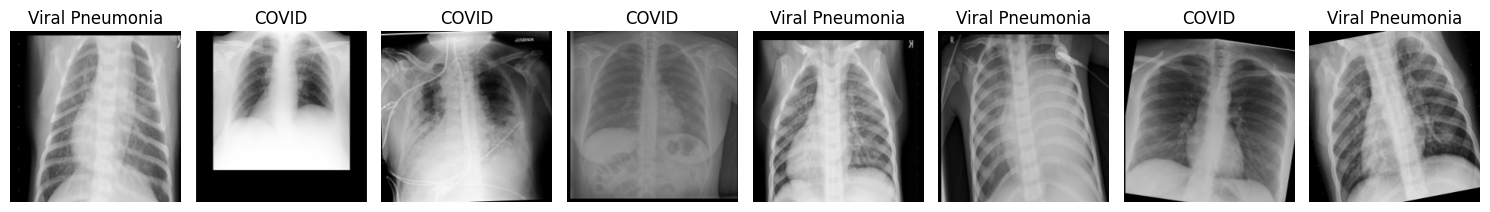

In [ ]:
# Sample only minority class images to ensure augmentation is applied
minority_img_paths = [p for p, l in zip(train_imgs, train_labels) if l in minority_classes]
minority_labels = [l for l in train_labels if l in minority_classes]

# Create and show one batch
aug_dataset = create_classification_dataset(minority_img_paths, minority_labels, batch_size=8)

def show_batch(dataset, n=8):
    import matplotlib.pyplot as plt
    INDEX_TO_CLASS = {v: k for k, v in CLASS_TO_INDEX.items()}
    for images, labels in dataset.take(1):
        plt.figure(figsize=(15, 5))
        for i in range(n):
            ax = plt.subplot(1, n, i+1)
            plt.imshow(images[i].numpy())
            plt.title(INDEX_TO_CLASS[labels[i].numpy()])
            plt.axis("off")
        plt.tight_layout()
        plt.show()

show_batch(aug_dataset)


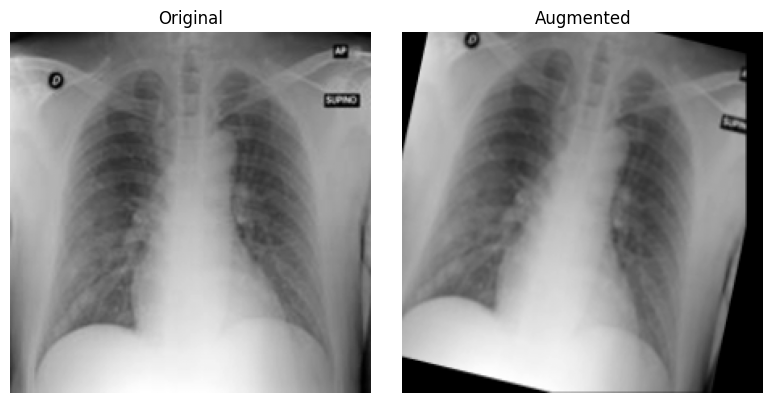

In [ ]:
def visualize_augmentation(img_path):
    import matplotlib.pyplot as plt

    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

    augmented = augment(image=np.expand_dims(img, -1))['image']
    augmented = np.squeeze(augmented)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(augmented, cmap='gray')
    axs[1].set_title("Augmented")
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()

# Example usage
visualize_augmentation(minority_img_paths[0])


#prepare test data


In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
from pathlib import Path

TEST_DATA_DIR = Path("/content/data/processed/test_data_with_masks")

X_test_raw = []
y_test_raw = []

for cls_index, cls_name in enumerate(CLASSES):
    img_dir = TEST_DATA_DIR / cls_name / "images"
    img_files = list(img_dir.glob("*"))

    for img_file in img_files:
        img = load_img(img_file, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
        img_array = img_to_array(img).astype(np.float32) / 255.0
        img_array = np.repeat(img_array, repeats=3, axis=-1)  # Convert grayscale to RGB

        X_test_raw.append(img_array)
        y_test_raw.append(cls_index)  # Image-level class label

# Convert to NumPy arrays
X_test = np.array(X_test_raw, dtype=np.float32)
y_test = np.array(y_test_raw, dtype=np.int32)

print("X_test shape:", X_test.shape)  # (N, 224, 224, 3)
print("y_test shape:", y_test.shape)  # (N,)



X_test shape: (3176, 224, 224, 3)
y_test shape: (3176,)


In [ ]:

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



#define model


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load VGG16 base without top
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze VGG16 layers

# Input
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # Pass input through VGG16

# Classification head
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(4, activation='softmax')(x)  #

# Build and compile model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,766,852 (60.15 MB)

 Trainable params: 1,052,164 (4.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.utils import plot_model

# Update this path to desired Google Drive folder
save_path = '/content/drive/MyDrive/model1.png'

plot_model(model, to_file=save_path, show_shapes=True, show_layer_names=True)
print(f"Model plot saved to: {save_path}")


Model plot saved to: /content/drive/MyDrive/model1.png


In [ ]:
EPOCHS = 5
steps_per_epoch = len(train_imgs) // BATCH_SIZE
validation_steps = len(val_imgs) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
)

Epoch 1/5
899/899 ━━━━━━━━━━━━━━━━━━━━ 113s 115ms/step - accuracy: 0.6914 - loss: 0.7859 - val_accuracy: 0.8560 - val_loss: 0.3858
Epoch 2/5
  1/899 ━━━━━━━━━━━━━━━━━━━━ 1:17:28 5s/step - accuracy: 0.7143 - loss: 0.8668

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


899/899 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - accuracy: 0.7143 - loss: 0.8668 - val_accuracy: 0.8318 - val_loss: 0.4481
Epoch 3/5
899/899 ━━━━━━━━━━━━━━━━━━━━ 110s 122ms/step - accuracy: 0.8423 - loss: 0.4237 - val_accuracy: 0.8703 - val_loss: 0.3559
Epoch 4/5
899/899 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 1.0000 - loss: 0.1549 - val_accuracy: 0.8717 - val_loss: 0.3515
Epoch 5/5
899/899 ━━━━━━━━━━━━━━━━━━━━ 113s 126ms/step - accuracy: 0.8599 - loss: 0.3818 - val_accuracy: 0.8739 - val_loss: 0.3506


In [ ]:
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]:.4f} - Test Accuracy: {results[1]:.4f}")
#83 %

199/199 ━━━━━━━━━━━━━━━━━━━━ 25s 118ms/step - accuracy: 0.8620 - loss: 0.3999
Test Loss: 0.4798 - Test Accuracy: 0.8193


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# save

In [ ]:
save_path = '/content/drive/MyDrive/model_vgg16_fullsize.keras'


In [ ]:
model.save(save_path)


# predictions

In [ ]:
import numpy as np

# Predict probabilities
y_pred_probs = model.predict(test_dataset)

# Convert probs to class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # shape: (num_samples,)


NameError: name 'test_dataset' is not defined

In [ ]:
y_true = y_test  # shape: (num_samples,)


# classification report

In [ ]:

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=CLASSES))

                 precision    recall  f1-score   support

         Normal       0.84      0.80      0.82      1529
          COVID       0.54      0.93      0.68       543
   Lung_Opacity       0.87      0.71      0.78       902
Viral Pneumonia       0.98      0.22      0.36       202

       accuracy                           0.76      3176
      macro avg       0.81      0.67      0.66      3176
   weighted avg       0.81      0.76      0.76      3176



#UNFREEZER LAST 4 LAYERS

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# Load base VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze last 4 convolutional layers
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Build the classification model
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)  # Set training=True for fine-tuning
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(4, activation='softmax')(x)  # Make sure NUM_CLASSES = 4

model = Model(inputs=inputs, outputs=outputs)

# Compile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Optional callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]




save model

In [ ]:
from tensorflow.keras.utils import plot_model

# Update this path to  desired Google Drive folder
save_path = '/content/drive/MyDrive/model2.png'

plot_model(model, to_file=save_path, show_shapes=True, show_layer_names=True)
print(f"Model plot saved to: {save_path}")


Model plot saved to: /content/drive/MyDrive/model2.png


train

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
)


Epoch 1/5
    900/Unknown 118s 125ms/step - accuracy: 0.6538 - loss: 0.8297

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


900/900 ━━━━━━━━━━━━━━━━━━━━ 149s 160ms/step - accuracy: 0.6540 - loss: 0.8294 - val_accuracy: 0.8819 - val_loss: 0.3266
Epoch 2/5
900/900 ━━━━━━━━━━━━━━━━━━━━ 132s 147ms/step - accuracy: 0.8894 - loss: 0.3151 - val_accuracy: 0.8827 - val_loss: 0.3377
Epoch 3/5
900/900 ━━━━━━━━━━━━━━━━━━━━ 133s 147ms/step - accuracy: 0.9180 - loss: 0.2406 - val_accuracy: 0.9152 - val_loss: 0.2363
Epoch 4/5
900/900 ━━━━━━━━━━━━━━━━━━━━ 133s 147ms/step - accuracy: 0.9246 - loss: 0.2162 - val_accuracy: 0.9261 - val_loss: 0.2008
Epoch 5/5
900/900 ━━━━━━━━━━━━━━━━━━━━ 133s 147ms/step - accuracy: 0.9319 - loss: 0.1901 - val_accuracy: 0.9266 - val_loss: 0.1887


In [ ]:
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]:.4f} - Test Accuracy: {results[1]:.4f}")


199/199 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - accuracy: 0.9069 - loss: 0.2500
Test Loss: 0.3241 - Test Accuracy: 0.8810


plot epoch loss and accuracy

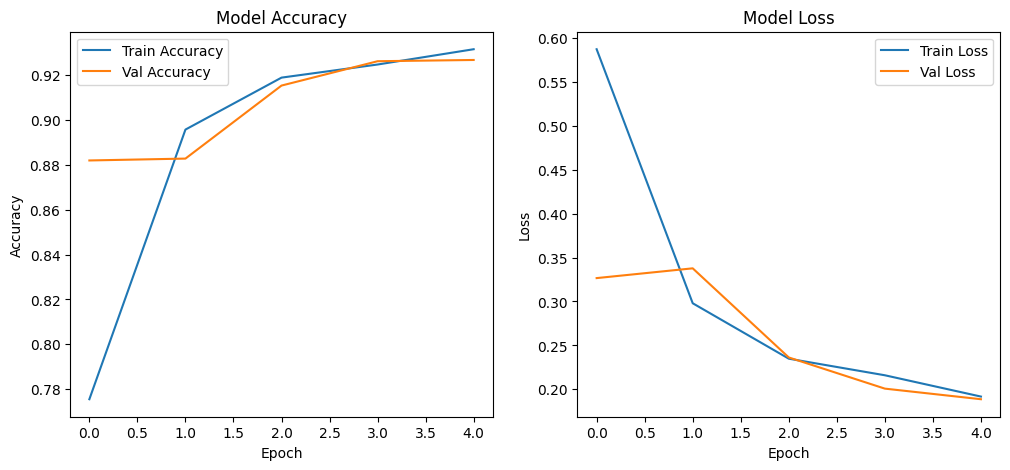

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Plot training & validation accuracy values
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

plot confusion matrix

199/199 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step


<Figure size 800x800 with 0 Axes>

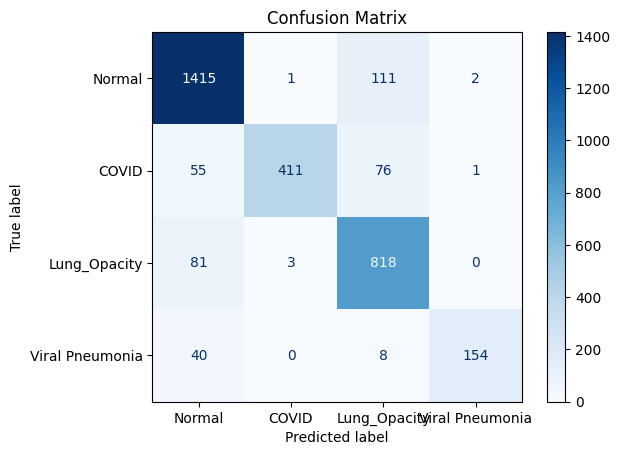

In [ ]:
import numpy as np

# Predict probabilities
y_pred_probs = model.predict(test_dataset)

# Convert probs to class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # shape: (num_samples,)
y_true = y_test  # shape: (num_samples,)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)

plt.figure(figsize=(8,8))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



plot classifictaion report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=CLASSES))

                 precision    recall  f1-score   support

         Normal       0.89      0.93      0.91      1529
          COVID       0.99      0.76      0.86       543
   Lung_Opacity       0.81      0.91      0.85       902
Viral Pneumonia       0.98      0.76      0.86       202

       accuracy                           0.88      3176
      macro avg       0.92      0.84      0.87      3176
   weighted avg       0.89      0.88      0.88      3176



save

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/model_vgg16_fullsize2.keras'
model.save(save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
save_path = '/content/drive/MyDrive/model_vgg16_fullsize2.keras'
model.save(save_path)

#Unfreeze last 8 layers


In [ ]:
#Key Improvements:
#More fine-tuned layers (last 8 instead of 4 for deeper adaptation).
#Batch normalization after Dense layers (helps with stable learning).
#Model checkpoint saving best model.
#Efficient learning rate schedule + monitoring
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# ---- Base Model ----
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last 8 conv layers
for layer in base_model.layers[:-8]:
    layer.trainable = False
for layer in base_model.layers[-8:]:
    layer.trainable = True

# ---- Classification Head ----
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs, outputs)

# ---- Compile Model ----
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ---- Callbacks ----
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6),
    ModelCheckpoint("best_model_vgg16_finetuned.h5", save_best_only=True, monitor='val_loss')
]



save

In [ ]:
from tensorflow.keras.utils import plot_model

# Update this path to your desired Google Drive folder
save_path = '/content/drive/MyDrive/model3.png'

plot_model(model, to_file=save_path, show_shapes=True, show_layer_names=True)
print(f"Model plot saved to: {save_path}")


Model plot saved to: /content/drive/MyDrive/model3.png


train

In [ ]:
# ---- Train Model ----
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
    900/Unknown 162s 167ms/step - accuracy: 0.6675 - loss: 0.9380

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


900/900 ━━━━━━━━━━━━━━━━━━━━ 187s 194ms/step - accuracy: 0.6676 - loss: 0.9377 - val_accuracy: 0.8822 - val_loss: 0.3619 - learning_rate: 1.0000e-05
Epoch 2/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8710 - loss: 0.4120

900/900 ━━━━━━━━━━━━━━━━━━━━ 169s 187ms/step - accuracy: 0.8710 - loss: 0.4120 - val_accuracy: 0.8966 - val_loss: 0.2903 - learning_rate: 1.0000e-05
Epoch 3/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 168s 186ms/step - accuracy: 0.9009 - loss: 0.3160 - val_accuracy: 0.8630 - val_loss: 0.3915 - learning_rate: 1.0000e-05
Epoch 4/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 168s 186ms/step - accuracy: 0.9043 - loss: 0.2887 - val_accuracy: 0.8772 - val_loss: 0.3581 - learning_rate: 1.0000e-05
Epoch 5/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9204 - loss: 0.2415

900/900 ━━━━━━━━━━━━━━━━━━━━ 169s 187ms/step - accuracy: 0.9204 - loss: 0.2415 - val_accuracy: 0.9386 - val_loss: 0.1745 - learning_rate: 2.0000e-06
Epoch 6/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 168s 186ms/step - accuracy: 0.9273 - loss: 0.2231 - val_accuracy: 0.9411 - val_loss: 0.1840 - learning_rate: 2.0000e-06
Epoch 7/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9320 - loss: 0.2069

900/900 ━━━━━━━━━━━━━━━━━━━━ 169s 187ms/step - accuracy: 0.9320 - loss: 0.2069 - val_accuracy: 0.9416 - val_loss: 0.1657 - learning_rate: 2.0000e-06
Epoch 8/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9393 - loss: 0.1873

900/900 ━━━━━━━━━━━━━━━━━━━━ 168s 187ms/step - accuracy: 0.9393 - loss: 0.1873 - val_accuracy: 0.9452 - val_loss: 0.1591 - learning_rate: 2.0000e-06
Epoch 9/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 168s 187ms/step - accuracy: 0.9386 - loss: 0.1828 - val_accuracy: 0.9394 - val_loss: 0.1711 - learning_rate: 2.0000e-06
Epoch 10/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9382 - loss: 0.1831

900/900 ━━━━━━━━━━━━━━━━━━━━ 169s 187ms/step - accuracy: 0.9382 - loss: 0.1831 - val_accuracy: 0.9452 - val_loss: 0.1513 - learning_rate: 2.0000e-06
Epoch 11/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 168s 187ms/step - accuracy: 0.9476 - loss: 0.1557 - val_accuracy: 0.9419 - val_loss: 0.1644 - learning_rate: 2.0000e-06
Epoch 12/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 168s 186ms/step - accuracy: 0.9489 - loss: 0.1491 - val_accuracy: 0.9377 - val_loss: 0.1896 - learning_rate: 2.0000e-06
Epoch 13/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 168s 186ms/step - accuracy: 0.9506 - loss: 0.1459 - val_accuracy: 0.9480 - val_loss: 0.1592 - learning_rate: 1.0000e-06
Epoch 14/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 168s 186ms/step - accuracy: 0.9529 - loss: 0.1432 - val_accuracy: 0.9466 - val_loss: 0.1514 - learning_rate: 1.0000e-06
Epoch 15/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 168s 186ms/step - accuracy: 0.9581 - loss: 0.1304 - val_accuracy: 0.9483 - val_loss: 0.1577 - learning_rate: 1.0000e-06


evaluate

In [ ]:
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]:.4f} - Test Accuracy: {results[1]:.4f}")


199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.9359 - loss: 0.1726
Test Loss: 0.2546 - Test Accuracy: 0.9106


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/model_vgg16_fullsize3.keras'
model.save(save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
save_path = '/content/drive/MyDrive/model_vgg16_fullsize3.keras'
model.save(save_path)

confusion matirx

199/199 ━━━━━━━━━━━━━━━━━━━━ 22s 107ms/step


<Figure size 800x800 with 0 Axes>

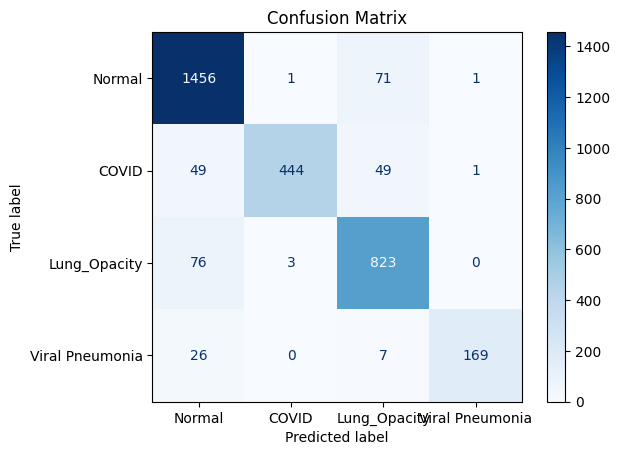

In [ ]:
import numpy as np

# Predict probabilities
y_pred_probs = model.predict(test_dataset)

# Convert probs to class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # shape: (num_samples,)
y_true = y_test  # shape: (num_samples,)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)

plt.figure(figsize=(8,8))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


classification report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=CLASSES))

                 precision    recall  f1-score   support

         Normal       0.91      0.95      0.93      1529
          COVID       0.99      0.82      0.90       543
   Lung_Opacity       0.87      0.91      0.89       902
Viral Pneumonia       0.99      0.84      0.91       202

       accuracy                           0.91      3176
      macro avg       0.94      0.88      0.90      3176
   weighted avg       0.91      0.91      0.91      3176



plot epoch accuracy and loss

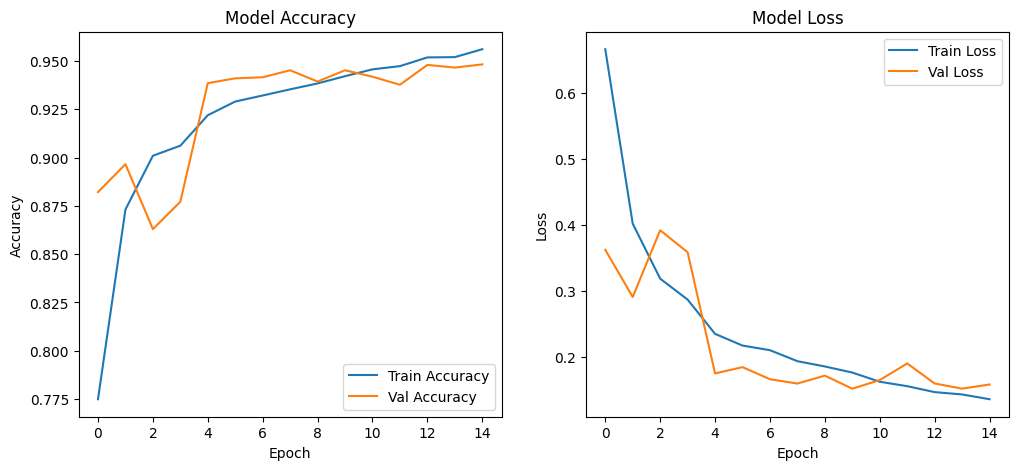

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

#last 8 layers for gradcam

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def add_dummy_target(image, label):
    dummy = tf.zeros((1,))  # or any shape; will be ignored
    return image, (dummy, label)

train_dataset = train_dataset.map(add_dummy_target)
val_dataset = val_dataset.map(add_dummy_target)


# Load VGG16 without top
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze last 8 layers
for layer in base_model.layers[:-8]:
    layer.trainable = False
for layer in base_model.layers[-8:]:
    layer.trainable = True

# Input
inputs = base_model.input  # use the original input of VGG16

# Get the output of last conv layer
last_conv_output = base_model.get_layer("block5_conv3").output

# Use it as base feature map
x = last_conv_output

# Classification head
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax', name="predictions")(x)

# Final model with both outputs: conv + predictions
model = Model(inputs=inputs, outputs=[last_conv_output, predictions])

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=['mse', 'sparse_categorical_crossentropy'],
    loss_weights=[0, 1],
    metrics={'predictions': 'accuracy'}
)
# ---- Callbacks ----
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6),
    ModelCheckpoint("best_model_vgg16_finetuned_gradcam.h5", save_best_only=True, monitor='val_loss')
]




train

In [ ]:
# ---- Train Model ----
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=callbacks
)



Epoch 1/20
    900/Unknown 157s 161ms/step - block5_conv3_loss: 0.2843 - loss: 0.9238 - predictions_accuracy: 0.6846 - predictions_loss: 0.9238

900/900 ━━━━━━━━━━━━━━━━━━━━ 187s 195ms/step - block5_conv3_loss: 0.2843 - loss: 0.9236 - predictions_accuracy: 0.6847 - predictions_loss: 0.9236 - val_block5_conv3_loss: 0.2895 - val_loss: 0.3778 - val_predictions_accuracy: 0.8916 - val_predictions_loss: 0.3776 - learning_rate: 1.0000e-05
Epoch 2/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - block5_conv3_loss: 0.2912 - loss: 0.4364 - predictions_accuracy: 0.8663 - predictions_loss: 0.4364

900/900 ━━━━━━━━━━━━━━━━━━━━ 168s 187ms/step - block5_conv3_loss: 0.2912 - loss: 0.4364 - predictions_accuracy: 0.8663 - predictions_loss: 0.4364 - val_block5_conv3_loss: 0.2998 - val_loss: 0.2666 - val_predictions_accuracy: 0.9152 - val_predictions_loss: 0.2665 - learning_rate: 1.0000e-05
Epoch 3/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - block5_conv3_loss: 0.2962 - loss: 0.3405 - predictions_accuracy: 0.8904 - predictions_loss: 0.3405

900/900 ━━━━━━━━━━━━━━━━━━━━ 170s 189ms/step - block5_conv3_loss: 0.2962 - loss: 0.3405 - predictions_accuracy: 0.8904 - predictions_loss: 0.3405 - val_block5_conv3_loss: 0.2868 - val_loss: 0.2047 - val_predictions_accuracy: 0.9283 - val_predictions_loss: 0.2046 - learning_rate: 1.0000e-05
Epoch 4/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 170s 189ms/step - block5_conv3_loss: 0.2943 - loss: 0.2879 - predictions_accuracy: 0.9060 - predictions_loss: 0.2879 - val_block5_conv3_loss: 0.2956 - val_loss: 0.3583 - val_predictions_accuracy: 0.8863 - val_predictions_loss: 0.3584 - learning_rate: 1.0000e-05
Epoch 5/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - block5_conv3_loss: 0.3012 - loss: 0.2730 - predictions_accuracy: 0.9084 - predictions_loss: 0.2730

900/900 ━━━━━━━━━━━━━━━━━━━━ 171s 189ms/step - block5_conv3_loss: 0.3012 - loss: 0.2730 - predictions_accuracy: 0.9084 - predictions_loss: 0.2730 - val_block5_conv3_loss: 0.2921 - val_loss: 0.1978 - val_predictions_accuracy: 0.9336 - val_predictions_loss: 0.1979 - learning_rate: 1.0000e-05
Epoch 6/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 170s 189ms/step - block5_conv3_loss: 0.2917 - loss: 0.2227 - predictions_accuracy: 0.9272 - predictions_loss: 0.2227 - val_block5_conv3_loss: 0.2871 - val_loss: 0.2028 - val_predictions_accuracy: 0.9361 - val_predictions_loss: 0.2028 - learning_rate: 1.0000e-05
Epoch 7/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 170s 189ms/step - block5_conv3_loss: 0.2873 - loss: 0.2222 - predictions_accuracy: 0.9297 - predictions_loss: 0.2222 - val_block5_conv3_loss: 0.2845 - val_loss: 0.3291 - val_predictions_accuracy: 0.9077 - val_predictions_loss: 0.3292 - learning_rate: 1.0000e-05
Epoch 8/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - block5_conv3_loss: 0.2830 - loss: 0.1567 - predic

900/900 ━━━━━━━━━━━━━━━━━━━━ 171s 189ms/step - block5_conv3_loss: 0.2830 - loss: 0.1566 - predictions_accuracy: 0.9505 - predictions_loss: 0.1566 - val_block5_conv3_loss: 0.2785 - val_loss: 0.1803 - val_predictions_accuracy: 0.9483 - val_predictions_loss: 0.1805 - learning_rate: 2.0000e-06
Epoch 9/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 171s 189ms/step - block5_conv3_loss: 0.2791 - loss: 0.1267 - predictions_accuracy: 0.9545 - predictions_loss: 0.1267 - val_block5_conv3_loss: 0.2745 - val_loss: 0.1889 - val_predictions_accuracy: 0.9455 - val_predictions_loss: 0.1888 - learning_rate: 2.0000e-06
Epoch 10/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 170s 189ms/step - block5_conv3_loss: 0.2750 - loss: 0.1280 - predictions_accuracy: 0.9569 - predictions_loss: 0.1280 - val_block5_conv3_loss: 0.2738 - val_loss: 0.1918 - val_predictions_accuracy: 0.9411 - val_predictions_loss: 0.1917 - learning_rate: 2.0000e-06
Epoch 11/20
900/900 ━━━━━━━━━━━━━━━━━━━━ 170s 189ms/step - block5_conv3_loss: 0.2737 - loss: 0.1078 - pr

save

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/best_model_vgg16_finetuned_gradcam.keras'
model.save(save_path)

Mounted at /content/drive


#unfreeze last 15 low lr

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Load VGG16 base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-15:]:
    layer.trainable = True


# Classification head
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)  # NUM_CLASSES = 4

model = Model(inputs=inputs, outputs=outputs)

# Compile with low LR for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#  Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6),
    ModelCheckpoint('vgg16_finetuned_all_layers.h5', save_best_only=True, monitor='val_accuracy', verbose=1)
]



save

In [ ]:
from tensorflow.keras.utils import plot_model

# Update this path to desired Google Drive folder
save_path = '/content/drive/MyDrive/model4.png'

plot_model(model, to_file=save_path, show_shapes=True, show_layer_names=True)
print(f"Model plot saved to: {save_path}")


Model plot saved to: /content/drive/MyDrive/model4.png


train

In [ ]:
# Training
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    steps_per_epoch=len(train_imgs) // BATCH_SIZE,
    validation_steps=len(val_imgs) // BATCH_SIZE,
    callbacks=callbacks
)


Epoch 1/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.6839 - loss: 0.7813
Epoch 1: val_accuracy improved from -inf to 0.88225, saving model to vgg16_finetuned_all_layers.h5


899/899 ━━━━━━━━━━━━━━━━━━━━ 284s 288ms/step - accuracy: 0.6841 - loss: 0.7810 - val_accuracy: 0.8823 - val_loss: 0.3211 - learning_rate: 1.0000e-05
Epoch 2/10
  1/899 ━━━━━━━━━━━━━━━━━━━━ 3:26:12 14s/step - accuracy: 1.0000 - loss: 0.2016

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.88225
899/899 ━━━━━━━━━━━━━━━━━━━━ 36s 25ms/step - accuracy: 1.0000 - loss: 0.2016 - val_accuracy: 0.8753 - val_loss: 0.3474 - learning_rate: 1.0000e-05
Epoch 3/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9024 - loss: 0.2769
Epoch 3: val_accuracy improved from 0.88225 to 0.90709, saving model to vgg16_finetuned_all_layers.h5


899/899 ━━━━━━━━━━━━━━━━━━━━ 259s 287ms/step - accuracy: 0.9024 - loss: 0.2769 - val_accuracy: 0.9071 - val_loss: 0.2555 - learning_rate: 1.0000e-05
Epoch 4/10
  1/899 ━━━━━━━━━━━━━━━━━━━━ 2:02 137ms/step - accuracy: 0.7143 - loss: 0.4943
Epoch 4: val_accuracy improved from 0.90709 to 0.91183, saving model to vgg16_finetuned_all_layers.h5


899/899 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.7143 - loss: 0.4943 - val_accuracy: 0.9118 - val_loss: 0.2465 - learning_rate: 1.0000e-05
Epoch 5/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9264 - loss: 0.2121
Epoch 5: val_accuracy improved from 0.91183 to 0.92690, saving model to vgg16_finetuned_all_layers.h5


899/899 ━━━━━━━━━━━━━━━━━━━━ 259s 287ms/step - accuracy: 0.9264 - loss: 0.2121 - val_accuracy: 0.9269 - val_loss: 0.2080 - learning_rate: 1.0000e-05
Epoch 6/10
  1/899 ━━━━━━━━━━━━━━━━━━━━ 2:03 138ms/step - accuracy: 0.8571 - loss: 0.2202
Epoch 6: val_accuracy improved from 0.92690 to 0.93276, saving model to vgg16_finetuned_all_layers.h5


899/899 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.8571 - loss: 0.2202 - val_accuracy: 0.9328 - val_loss: 0.1956 - learning_rate: 1.0000e-05
Epoch 7/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9411 - loss: 0.1677
Epoch 7: val_accuracy improved from 0.93276 to 0.93583, saving model to vgg16_finetuned_all_layers.h5


899/899 ━━━━━━━━━━━━━━━━━━━━ 258s 287ms/step - accuracy: 0.9411 - loss: 0.1677 - val_accuracy: 0.9358 - val_loss: 0.1837 - learning_rate: 1.0000e-05
Epoch 8/10
  1/899 ━━━━━━━━━━━━━━━━━━━━ 2:05 140ms/step - accuracy: 0.7143 - loss: 0.3631
Epoch 8: val_accuracy improved from 0.93583 to 0.94252, saving model to vgg16_finetuned_all_layers.h5


899/899 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.7143 - loss: 0.3631 - val_accuracy: 0.9425 - val_loss: 0.1626 - learning_rate: 1.0000e-05
Epoch 9/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9433 - loss: 0.1597
Epoch 9: val_accuracy did not improve from 0.94252
899/899 ━━━━━━━━━━━━━━━━━━━━ 258s 287ms/step - accuracy: 0.9433 - loss: 0.1597 - val_accuracy: 0.9403 - val_loss: 0.1535 - learning_rate: 1.0000e-05
Epoch 10/10
  1/899 ━━━━━━━━━━━━━━━━━━━━ 2:00 134ms/step - accuracy: 0.8571 - loss: 0.2071
Epoch 10: val_accuracy did not improve from 0.94252
899/899 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.8571 - loss: 0.2071 - val_accuracy: 0.9395 - val_loss: 0.1563 - learning_rate: 1.0000e-05


evaluate

In [ ]:
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]:.4f} - Test Accuracy: {results[1]:.4f}")


199/199 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.9201 - loss: 0.1971
Test Loss: 0.2703 - Test Accuracy: 0.8992


plot confusion matrix

199/199 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step


<Figure size 800x800 with 0 Axes>

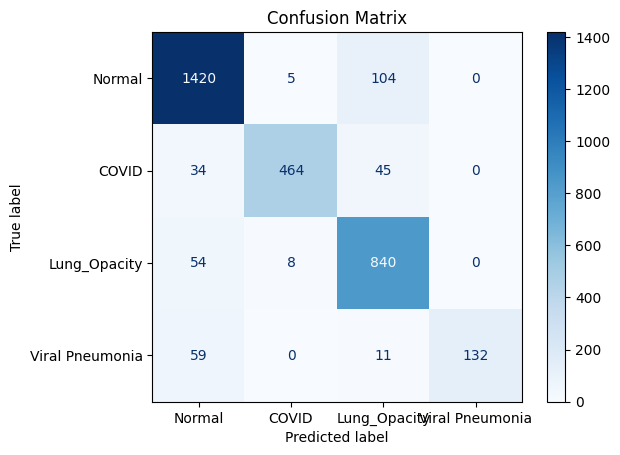

In [ ]:
import numpy as np

# Predict probabilities
y_pred_probs = model.predict(test_dataset)

# Convert probs to class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # shape: (num_samples,)
y_true = y_test  # shape: (num_samples,)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)

plt.figure(figsize=(8,8))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


plot classifciation report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=CLASSES))

                 precision    recall  f1-score   support

         Normal       0.91      0.93      0.92      1529
          COVID       0.97      0.85      0.91       543
   Lung_Opacity       0.84      0.93      0.88       902
Viral Pneumonia       1.00      0.65      0.79       202

       accuracy                           0.90      3176
      macro avg       0.93      0.84      0.88      3176
   weighted avg       0.90      0.90      0.90      3176



plot epoch loss and accuracy

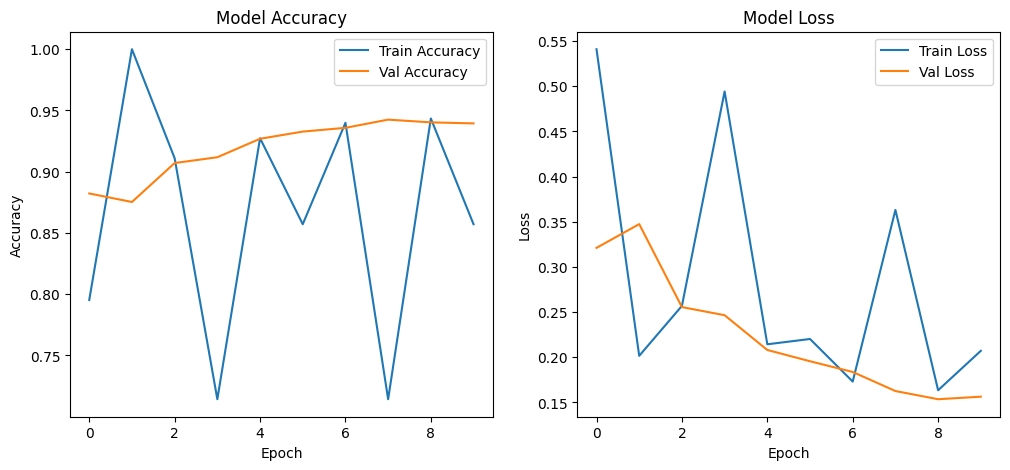

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

save

In [ ]:
save_path = '/content/drive/MyDrive/model_vgg16_fullsizebest.keras'
model.save(save_path)


#vgg + se block


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dense, Dropout,
    GlobalAveragePooling2D, Reshape, Multiply, Activation, Dense
)

# === SE block definition ===
def se_block(input_tensor, reduction=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // reduction, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    x = Multiply()([input_tensor, se])
    return x

# === Load VGG16 base ===
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# === Apply SE block after last conv layer of block5 ===
x = base_model.output  # output of block5_conv3
x = se_block(x)

# === Classification head ===
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)

# === Build final model ===
model = Model(inputs=base_model.input, outputs=outputs)

# === Fine-tune last 15 layers ===
for layer in model.layers[:-15]:
    layer.trainable = False
for layer in model.layers[-15:]:
    layer.trainable = True

# === Compile ===
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 15,800,164 (60.27 MB)

 Trainable params: 8,164,900 (31.15 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks for better training control
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('vgg16_se_best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Assuming you have your training and validation data ready:
# train_dataset, val_dataset = ...

# Example using model.fit() with datasets or numpy arrays:
history = model.fit(
    train_dataset,        # Your training data (tf.data.Dataset or (X_train, y_train))
    validation_data=val_dataset,  # Your validation data (tf.data.Dataset or (X_val, y_val))
    epochs=30,            # You can increase this if needed
    callbacks=callbacks,
    batch_size=32,        # Adjust as per your GPU memory
    verbose=1
)


Epoch 1/30
    900/Unknown 124s 124ms/step - accuracy: 0.6268 - loss: 0.9002

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.85770, saving model to vgg16_se_best_model.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 154s 157ms/step - accuracy: 0.6270 - loss: 0.8999 - val_accuracy: 0.8577 - val_loss: 0.4073 - learning_rate: 1.0000e-05
Epoch 2/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8782 - loss: 0.3487
Epoch 2: val_accuracy improved from 0.85770 to 0.89689, saving model to vgg16_se_best_model.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 129s 143ms/step - accuracy: 0.8782 - loss: 0.3487 - val_accuracy: 0.8969 - val_loss: 0.2892 - learning_rate: 1.0000e-05
Epoch 3/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9056 - loss: 0.2719
Epoch 3: val_accuracy improved from 0.89689 to 0.90717, saving model to vgg16_se_best_model.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 129s 143ms/step - accuracy: 0.9056 - loss: 0.2719 - val_accuracy: 0.9072 - val_loss: 0.2689 - learning_rate: 1.0000e-05
Epoch 4/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9199 - loss: 0.2303
Epoch 4: val_accuracy improved from 0.90717 to 0.91940, saving model to vgg16_se_best_model.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 129s 143ms/step - accuracy: 0.9199 - loss: 0.2303 - val_accuracy: 0.9194 - val_loss: 0.2203 - learning_rate: 1.0000e-05
Epoch 5/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9260 - loss: 0.1989
Epoch 5: val_accuracy improved from 0.91940 to 0.92524, saving model to vgg16_se_best_model.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 129s 143ms/step - accuracy: 0.9260 - loss: 0.1989 - val_accuracy: 0.9252 - val_loss: 0.2014 - learning_rate: 1.0000e-05
Epoch 6/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9333 - loss: 0.1885
Epoch 6: val_accuracy improved from 0.92524 to 0.92913, saving model to vgg16_se_best_model.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 129s 143ms/step - accuracy: 0.9333 - loss: 0.1885 - val_accuracy: 0.9291 - val_loss: 0.1932 - learning_rate: 1.0000e-05
Epoch 7/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9408 - loss: 0.1676
Epoch 7: val_accuracy improved from 0.92913 to 0.93052, saving model to vgg16_se_best_model.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 129s 143ms/step - accuracy: 0.9408 - loss: 0.1676 - val_accuracy: 0.9305 - val_loss: 0.1894 - learning_rate: 1.0000e-05
Epoch 8/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9435 - loss: 0.1613
Epoch 8: val_accuracy did not improve from 0.93052
900/900 ━━━━━━━━━━━━━━━━━━━━ 129s 143ms/step - accuracy: 0.9435 - loss: 0.1613 - val_accuracy: 0.9200 - val_loss: 0.2297 - learning_rate: 1.0000e-05
Epoch 9/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9425 - loss: 0.1552
Epoch 9: val_accuracy improved from 0.93052 to 0.93274, saving model to vgg16_se_best_model.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 129s 143ms/step - accuracy: 0.9425 - loss: 0.1552 - val_accuracy: 0.9327 - val_loss: 0.1877 - learning_rate: 1.0000e-05
Epoch 10/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9490 - loss: 0.1397
Epoch 10: val_accuracy improved from 0.93274 to 0.93385, saving model to vgg16_se_best_model.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 129s 143ms/step - accuracy: 0.9490 - loss: 0.1397 - val_accuracy: 0.9339 - val_loss: 0.1841 - learning_rate: 1.0000e-05
Epoch 11/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9488 - loss: 0.1434
Epoch 11: val_accuracy did not improve from 0.93385
900/900 ━━━━━━━━━━━━━━━━━━━━ 128s 142ms/step - accuracy: 0.9488 - loss: 0.1434 - val_accuracy: 0.9252 - val_loss: 0.2026 - learning_rate: 1.0000e-05
Epoch 12/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9503 - loss: 0.1368
Epoch 12: val_accuracy did not improve from 0.93385
900/900 ━━━━━━━━━━━━━━━━━━━━ 128s 142ms/step - accuracy: 0.9503 - loss: 0.1368 - val_accuracy: 0.9297 - val_loss: 0.2020 - learning_rate: 1.0000e-05
Epoch 13/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9572 - loss: 0.1220
Epoch 13: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.

Epoch 13: val_accuracy did not improve from 0.93385
900/900 ━━━━━━━━━━━━━━━━━━━━ 128s 142ms/step - accu

900/900 ━━━━━━━━━━━━━━━━━━━━ 129s 143ms/step - accuracy: 0.9613 - loss: 0.1022 - val_accuracy: 0.9358 - val_loss: 0.1681 - learning_rate: 2.0000e-06
Epoch 15/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9666 - loss: 0.0963
Epoch 15: val_accuracy did not improve from 0.93580
900/900 ━━━━━━━━━━━━━━━━━━━━ 128s 142ms/step - accuracy: 0.9666 - loss: 0.0963 - val_accuracy: 0.9327 - val_loss: 0.1853 - learning_rate: 2.0000e-06
Epoch 16/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9654 - loss: 0.0990
Epoch 16: val_accuracy improved from 0.93580 to 0.93941, saving model to vgg16_se_best_model.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 129s 143ms/step - accuracy: 0.9654 - loss: 0.0990 - val_accuracy: 0.9394 - val_loss: 0.1699 - learning_rate: 2.0000e-06
Epoch 17/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9691 - loss: 0.0872
Epoch 17: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 17: val_accuracy did not improve from 0.93941
900/900 ━━━━━━━━━━━━━━━━━━━━ 128s 142ms/step - accuracy: 0.9691 - loss: 0.0872 - val_accuracy: 0.9369 - val_loss: 0.1719 - learning_rate: 2.0000e-06
Epoch 18/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9694 - loss: 0.0906
Epoch 18: val_accuracy did not improve from 0.93941
900/900 ━━━━━━━━━━━━━━━━━━━━ 128s 142ms/step - accuracy: 0.9694 - loss: 0.0906 - val_accuracy: 0.9394 - val_loss: 0.1735 - learning_rate: 1.0000e-06
Epoch 19/30
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9719 - loss: 0.0863
Epoch 19: val_accuracy did not improve from 0.93941
900/900 ━━━━━━━━━━━━━━━━━━━━ 129s 143ms/step - accuracy: 0.9719 - lo

evaluate

In [ ]:
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]:.4f} - Test Accuracy: {results[1]:.4f}")


199/199 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - accuracy: 0.9216 - loss: 0.2216
Test Loss: 0.2379 - Test Accuracy: 0.9175


confusion matrix

199/199 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step


<Figure size 800x800 with 0 Axes>

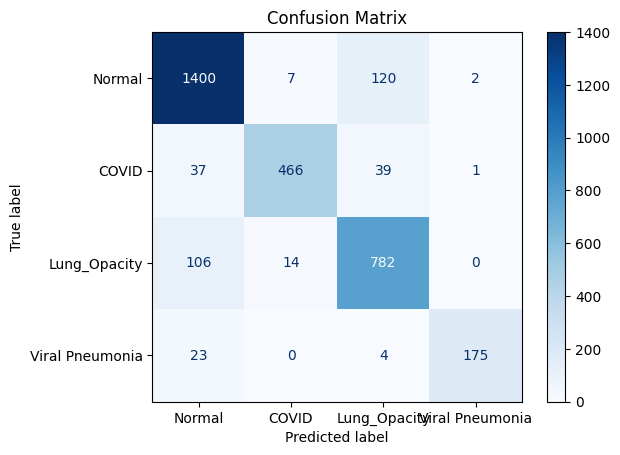

In [ ]:
import numpy as np

# Predict probabilities
y_pred_probs = model.predict(test_dataset)

# Convert probs to class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # shape: (num_samples,)
y_true = y_test  # shape: (num_samples,)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)

plt.figure(figsize=(8,8))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
#its wrong

clöassifciation report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=CLASSES))

#| Metric                 | Value | Comment                                      |
#| ---------------------- | ----- | -------------------------------------------- |
#| **Accuracy**           | 92%   | Strong performance overall                   |
#| **COVID F1**           | 94%   | Excellent, crucial for high-risk class       |
#| **Normal F1**          | 93%   | High reliability on healthy cases            |
#| **Lung\_Opacity F1**   | 89%   | Good, but there's room for improvement       |
#| **Viral Pneumonia F1** | 93%   | High precision, recall could be improved     |
#| **Macro Avg F1**       | 92%   | Very balanced performance across all classes |


                 precision    recall  f1-score   support

         Normal       0.93      0.92      0.93      1529
          COVID       0.98      0.90      0.94       543
   Lung_Opacity       0.85      0.93      0.89       902
Viral Pneumonia       0.98      0.88      0.93       202

       accuracy                           0.92      3176
      macro avg       0.94      0.91      0.92      3176
   weighted avg       0.92      0.92      0.92      3176



plot epoch  loss and accuracy

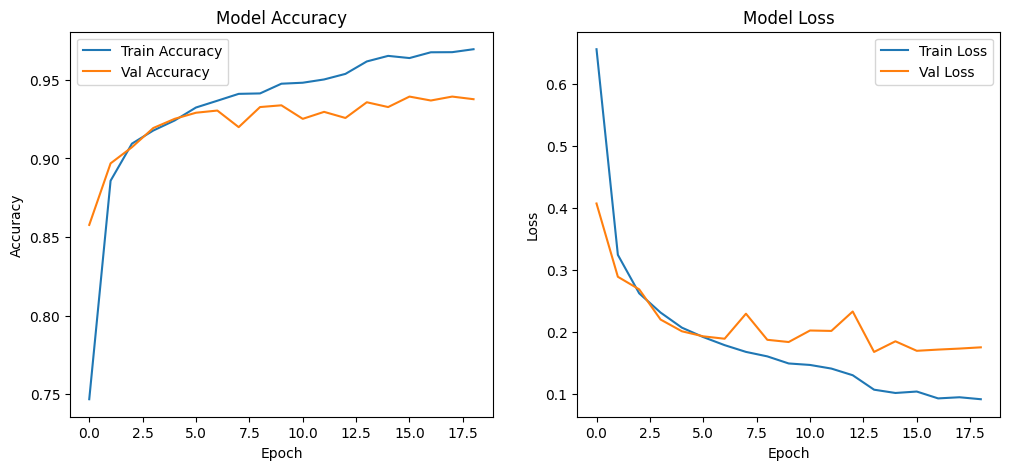

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/model_vgg16_fullsize_seblocks.keras'
model.save(save_path)


Mounted at /content/drive


#vgg+cbam

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D,
                                     Concatenate, Conv2D, Multiply, Activation, add)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.layers import Layer, Lambda

def cbam_block(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    # Channel attention
    avg_pool = GlobalAveragePooling2D()(input_feature)
    max_pool = GlobalMaxPooling2D()(input_feature)

    shared_dense_one = Dense(channel // ratio, activation='relu', use_bias=False)
    shared_dense_two = Dense(channel, use_bias=False)

    avg_out = shared_dense_two(shared_dense_one(avg_pool))
    max_out = shared_dense_two(shared_dense_one(max_pool))
    channel_attention = Activation('sigmoid')(add([avg_out, max_out]))

    # Expand dims using Lambda
    channel_attention = Lambda(lambda x: tf.expand_dims(tf.expand_dims(x, axis=1), axis=1))(channel_attention)
    channel_refined = Multiply()([input_feature, channel_attention])

    # Spatial attention
    avg_pool_spatial = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined)
    max_pool_spatial = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined)
    concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)

    refined_feature = Multiply()([channel_refined, spatial_attention])
    return refined_feature


# ==== Load VGG16 and attach CBAM ====
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False  # Fine-tune later if needed

# Inject CBAM after a deeper layer
x = base_model.get_layer('block4_conv3').output
x = cbam_block(x)
x = Lambda(lambda x: x, name="cbam_output")(x)  # 👈 Add this line
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# ==== Compile ====
model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ==== Prepare your tf.data.Dataset inputs ====
# (Replace this with your actual loading logic)
# Assume train_dataset and val_dataset are batched, prefetched tf.data.Dataset objects
# Example:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
# val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# Compute class weights from labels
train_labels = np.concatenate([y for x, y in train_dataset], axis=0)
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

# ==== Callbacks ====
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6),
    ModelCheckpoint('vgg16_cbam_best.keras', save_best_only=True, monitor='val_accuracy', verbose=1)
]

# ==== Train ====
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks
)

# ==== Save final model ====
model.save('vgg16_cbam_final.keras')

# ==== Optional: Dataset info ====
print(f"Train batches: {len(list(train_dataset))}")
print(f"Validation batches: {len(list(val_dataset))}")


Epoch 1/30
    900/Unknown 101s 99ms/step - accuracy: 0.6792 - loss: 0.8580

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.85158, saving model to vgg16_cbam_best.keras
900/900 ━━━━━━━━━━━━━━━━━━━━ 130s 131ms/step - accuracy: 0.6793 - loss: 0.8577 - val_accuracy: 0.8516 - val_loss: 0.3894 - learning_rate: 1.0000e-04
Epoch 2/30
899/900 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8447 - loss: 0.3669
Epoch 2: val_accuracy improved from 0.85158 to 0.88855, saving model to vgg16_cbam_best.keras
900/900 ━━━━━━━━━━━━━━━━━━━━ 105s 117ms/step - accuracy: 0.8448 - loss: 0.3669 - val_accuracy: 0.8885 - val_loss: 0.3160 - learning_rate: 1.0000e-04
Epoch 3/30
899/900 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8625 - loss: 0.3218
Epoch 3: val_accuracy improved from 0.88855 to 0.88938, saving model to vgg16_cbam_best.keras
900/900 ━━━━━━━━━━━━━━━━━━━━ 105s 116ms/step - accuracy: 0.8626 - loss: 0.3218 - val_accuracy: 0.8894 - val_loss: 0.3092 - learning_rate: 1.0000e-04
Epoch 4/30
899/900 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.8780 - loss: 0.2678
Epoch 4: val

evaluate

In [ ]:
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]:.4f} - Test Accuracy: {results[1]:.4f}")

199/199 ━━━━━━━━━━━━━━━━━━━━ 24s 114ms/step - accuracy: 0.9054 - loss: 0.2480
Test Loss: 0.2956 - Test Accuracy: 0.8889


plot confusion matrix

199/199 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step


<Figure size 800x800 with 0 Axes>

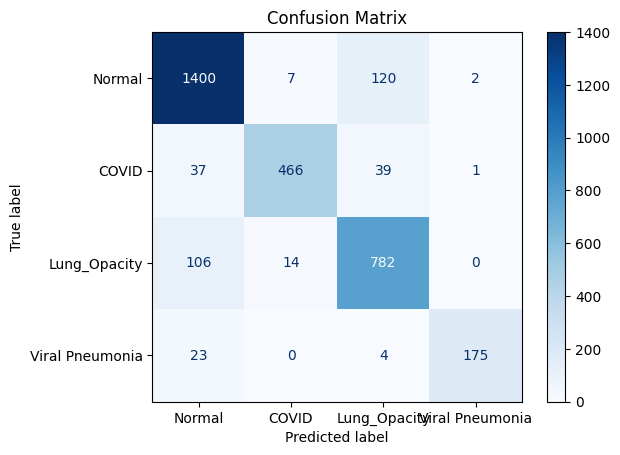

In [ ]:
import numpy as np

# Predict probabilities
y_pred_probs = model.predict(test_dataset)

# Convert probs to class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # shape: (num_samples,)
y_true = y_test  # shape: (num_samples,)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)

plt.figure(figsize=(8,8))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# classifictaion report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=CLASSES))

                 precision    recall  f1-score   support

         Normal       0.89      0.92      0.90      1529
          COVID       0.96      0.86      0.90       543
   Lung_Opacity       0.83      0.87      0.85       902
Viral Pneumonia       0.98      0.87      0.92       202

       accuracy                           0.89      3176
      macro avg       0.92      0.88      0.89      3176
   weighted avg       0.89      0.89      0.89      3176



plot epoch loss and accuracy

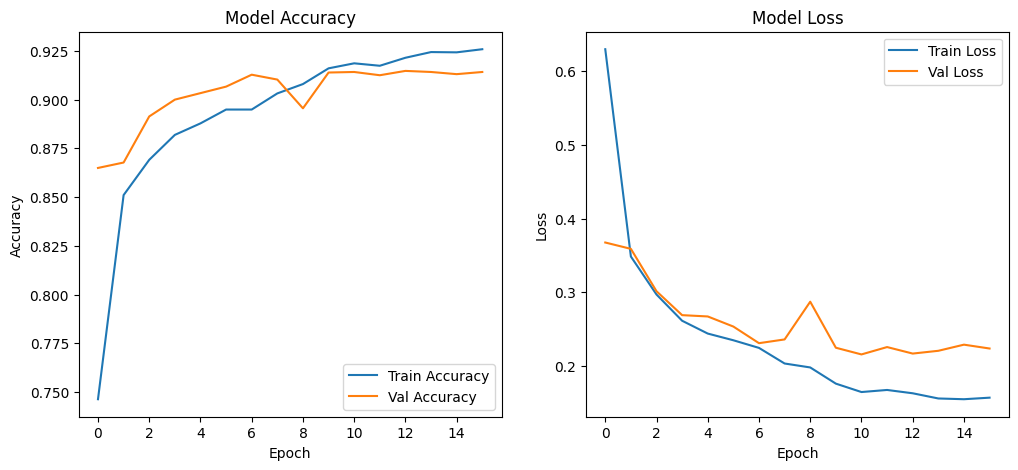

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/model_vgg16_fullsize_cbam.keras'
model.save(save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#efficient net


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import preprocess_input
# Load EfficientNetB0 base (frozen)
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Build classification model
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)  # training=False disables BN update
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(inputs=inputs, outputs=outputs)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6),
    ModelCheckpoint('efficientnet_phase1.h5', save_best_only=True, monitor='val_accuracy', verbose=1)
]



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# train

In [ ]:
# Train
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=callbacks
)



Epoch 1/10
    900/Unknown 74s 53ms/step - accuracy: 0.3024 - loss: 1.8732

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.49083, saving model to efficientnet_phase1.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 94s 75ms/step - accuracy: 0.3025 - loss: 1.8730 - val_accuracy: 0.4908 - val_loss: 1.1905 - learning_rate: 1.0000e-04
Epoch 2/10
899/900 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3903 - loss: 1.4947
Epoch 2: val_accuracy improved from 0.49083 to 0.54391, saving model to efficientnet_phase1.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 45s 50ms/step - accuracy: 0.3903 - loss: 1.4947 - val_accuracy: 0.5439 - val_loss: 1.1581 - learning_rate: 1.0000e-04
Epoch 3/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4173 - loss: 1.4142
Epoch 3: val_accuracy did not improve from 0.54391
900/900 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.4174 - loss: 1.4141 - val_accuracy: 0.1707 - val_loss: 1.7075 - learning_rate: 1.0000e-04
Epoch 4/10
899/900 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4456 - loss: 1.3316
Epoch 4: val_accuracy did not improve from 0.54391
900/900 ━━━━━━━━━━━━━━━━━━━━ 44s 48ms/step - accuracy: 0.4456 - loss: 1.3316 - val_accuracy: 0.5309 - val_loss: 1.0724 - learning_rate: 1.0000e-04
Epoch 5/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4741 - loss: 1.2732
Epoch 5: val_accuracy did not improve from 0.54391
900/900 ━━━━━━━━━━━━━━━━━━━━ 44s 48ms/step - accuracy: 0.4741 - loss: 1.2732 - val_accuracy: 0.4817 - val_loss: 1.7932 - learning_rate: 1.0000e-0

save

In [ ]:
from tensorflow.keras.utils import plot_model

# Update this path to your desired Google Drive folder
save_path = '/content/drive/MyDrive/model5.png'

plot_model(model, to_file=save_path, show_shapes=True, show_layer_names=True)
print(f"Model plot saved to: {save_path}")



Model plot saved to: /content/drive/MyDrive/model5.png


evaluate

In [ ]:
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]:.4f} - Test Accuracy: {results[1]:.4f}")


199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.5768 - loss: 0.9653
Test Loss: 1.1152 - Test Accuracy: 0.4559


get predictions

199/199 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step


<Figure size 800x800 with 0 Axes>

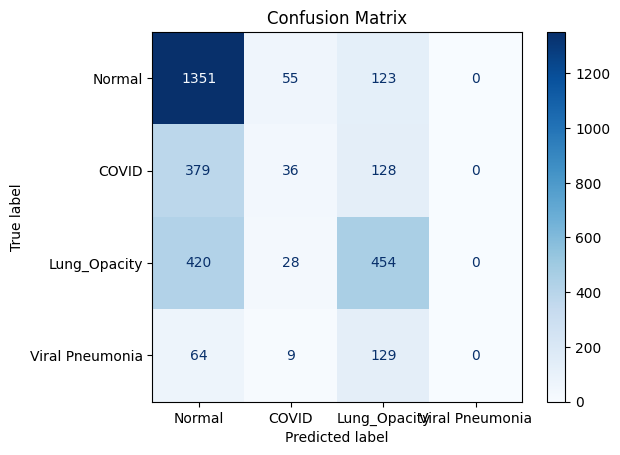

In [ ]:
import numpy as np

# Predict probabilities
y_pred_probs = model.predict(test_dataset)

# Convert probs to class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # shape: (num_samples,)
y_true = y_test  # shape: (num_samples,)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)

plt.figure(figsize=(8,8))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


classification report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=CLASSES))

                 precision    recall  f1-score   support

         Normal       0.61      0.88      0.72      1529
          COVID       0.28      0.07      0.11       543
   Lung_Opacity       0.54      0.50      0.52       902
Viral Pneumonia       0.00      0.00      0.00       202

       accuracy                           0.58      3176
      macro avg       0.36      0.36      0.34      3176
   weighted avg       0.50      0.58      0.51      3176



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#Dual-Input (Image + Mask) with Mask as Attention in VGG16

In [ ]:
import tensorflow as tf
import numpy as np
from pathlib import Path

# Constants
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
class_names = ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']
class_to_index = {name: i for i, name in enumerate(class_names)}

def load_image_mask_label(image_path, mask_path, label):
    # Load and decode image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image.set_shape([None, None, 3])  # Ensure known shape
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0

    # Load and decode mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_image(mask, channels=1)
    mask.set_shape([None, None, 1])  # Ensure known shape
    mask = tf.image.resize(mask, IMG_SIZE)
    mask = tf.cast(mask, tf.float32) / 255.0

    return (image, mask), label



In [ ]:
def build_file_list(data_root):
    image_paths = []
    mask_paths = []
    labels = []

    for class_name in class_names:
        class_img_dir = Path(data_root) / class_name / "images"
        class_mask_dir = Path(data_root) / class_name / "masks"

        for img_file in class_img_dir.glob("*"):
            image_paths.append(str(img_file))
            mask_paths.append(str(class_mask_dir / img_file.name))
            labels.append(class_to_index[class_name])

    return image_paths, mask_paths, labels

train_image_paths, train_mask_paths, train_labels = build_file_list("/content/data/processed/train_data_with_masks")
val_image_paths, val_mask_paths, val_labels = build_file_list("/content/data/processed/test_data_with_masks")


In [ ]:
def make_dataset(image_paths, mask_paths, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths, labels))
    dataset = dataset.map(
        lambda img, mask, label: load_image_mask_label(img, mask, label),
        num_parallel_calls=AUTOTUNE
    )
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    return dataset.batch(batch_size).prefetch(AUTOTUNE)

train_dataset = make_dataset(train_image_paths, train_mask_paths, train_labels)
val_dataset = make_dataset(val_image_paths, val_mask_paths, val_labels, shuffle=False)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Input, GlobalAveragePooling2D, Dense, Dropout,
    BatchNormalization, Multiply, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# --------- Model Definition ---------

# Inputs
rgb_input = Input(shape=(224, 224, 3), name="image_input")
mask_input = Input(shape=(224, 224, 1), name="mask_input")  # Binary or soft mask

# Load base VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=rgb_input)

# Freeze most layers
for layer in base_model.layers[:-8]:
    layer.trainable = False
for layer in base_model.layers[-8:]:
    layer.trainable = True

# Extract features from last conv layer
# Get last conv output
feature_map = base_model.get_layer("block5_conv3").output  # shape: (14, 14, 512) — verify this!

# Resize mask to match feature map shape
mask_resized = Lambda(lambda x: tf.image.resize(x, (14, 14)), name="resize_mask")(mask_input)

# Apply mask to feature map
attention_map = Multiply(name="attention")([feature_map, mask_resized])


# Classification head
x = GlobalAveragePooling2D()(attention_map)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax', name="predictions")(x)

# Define final model
model = Model(inputs=[rgb_input, mask_input], outputs=output)

# Compile
model.compile(
    optimizer=Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ image_input[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 15,772,996 (60.17 MB)

 Trainable params: 14,034,436 (53.54 MB)

 Non-trainable params: 1,738,560 (6.63 MB)

train

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.2),
        tf.keras.callbacks.ModelCheckpoint("best_masked_attention_model.h5", save_best_only=True)
    ]
)


Epoch 1/20
 80/563 ━━━━━━━━━━━━━━━━━━━━ 4:52:40 36s/step - accuracy: 0.3063 - loss: 1.9839

KeyboardInterrupt: 

save

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save model to your Drive
model_path = "/content/drive/MyDrive/best_masked_attention_model.h5"
model.save(model_path)
print(f"Model saved to: {model_path}")


Mounted at /content/drive


NameError: name 'model' is not defined

#Plot Training Accuracy & Loss

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training acc')
    plt.plot(epochs, val_acc, 'r-', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


# Confusion Matrix & Classification Report


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

# Step 1: Get ground truth and predictions
y_true = []
y_pred = []

for (images, masks), labels in val_dataset:
    preds = model.predict([images, masks])
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# Step 2: Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASSES))

# Step 3: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get true and predicted labels
true_labels = []
pred_labels = []

for (img, mask), label in val_dataset.unbatch():
    pred = model.predict(((tf.expand_dims(img, 0), tf.expand_dims(mask, 0))), verbose=0)

    if isinstance(pred, list) or isinstance(pred, tuple):
        pred_class = tf.argmax(pred[1], axis=1).numpy()[0]  # assuming 2nd output is classification
    else:
        pred_class = tf.argmax(pred, axis=1).numpy()[0]

    true_labels.append(label.numpy())
    pred_labels.append(pred_class)


In [ ]:
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


NameError: name 'confusion_matrix' is not defined

In [ ]:
report = classification_report(true_labels, pred_labels, target_names=CLASSES)
print("Classification Report:\n")
print(report)


NameError: name 'classification_report' is not defined